# Pick comparison as a function of time and overlap

In [1]:
import string
import time
import argparse as ap
import sys
import os
import obspy
import obspy.core as oc
from obspy.geodetics import kilometers2degrees
from obspy.geodetics import degrees2kilometers
from obspy.geodetics import FlinnEngdahl
from obspy.geodetics import gps2dist_azimuth
from obspy import read
from obspy import UTCDateTime
from obspy.core.event import  Event, Origin, Magnitude, Pick#, WaveformStreamID7

from obspy import read_events
from obspy import Catalog
import seaborn as SI
from datetime import datetime

import pandas as pd
import matplotlib as mpl
import pylab as plt
import numpy as np
import math


from obspy import read_inventory
from obspy.clients.filesystem.sds import Client

import glob



## Load catalogs

In [2]:
def read_phs(evepn):
    ######################################################
    ## This def is used to write PN catalogs without    ##
    ## the picks that are missed by PN-OR or PN-IN      ##
    ######################################################

    all_dfs = []  # Lista per raccogliere tutti i DataFrame
    for i, ev in enumerate(evepn):
        file_path = evepn[i]
        with open(file_path, 'r') as file:
            first_line = file.readline().strip()
            eve_id = first_line.split(' ')[1]
            
            # Lettura del file in un DataFrame temporaneo
            temp_df = pd.read_fwf(
                file, 
                colspecs=[(0, 5), (18, 20), (27, 32), (32, 34), (34, 36), (36, 39), (39, 41), (41, 49)], 
                header=None, 
                names=['station', 'phase_hint', 'year', 'month', 'day', 'hours', 'minutes', 'sec']
            )

            # Creazione della colonna UTCDateTime
            temp_df['UTCDateTime'] = temp_df.apply(
                lambda row: UTCDateTime(
                    int(row['year']), int(row['month']), int(row['day']), 
                    int(row['hours']), int(row['minutes']), float(row['sec'])
                ), axis=1
            )
            temp_df['eve_id'] = eve_id
            # Rimuove le colonne originali di data e ora
            temp_df = temp_df.drop(columns=['year', 'month', 'day', 'hours', 'minutes', 'sec'])
            
            # Aggiungi il DataFrame alla lista
            all_dfs.append(temp_df)

    # Concatena tutti i DataFrame in un unico DataFrame
    final_df = pd.concat(all_dfs, ignore_index=True)
    return final_df


In [3]:
## Leggo i file phs di INGV
pickdir="/home/jovyan/shared/users/spina/Norcia/NLLoc/OBS/NEW_INGV/"
pick_ingv=pickdir+'*.phs'
lista = glob.glob(pick_ingv)
pick_ingv_df=read_phs(lista)

In [4]:
## Leggo i file phs di PN-OR
pickdir="/home/jovyan/shared/users/spina/Norcia/NLLoc/OBS/NEW_PN_ORIG28/"
pick_pn_or=pickdir+'*.phs'
lista = glob.glob(pick_pn_or)
pick_or_df=read_phs(lista)

In [5]:
## Leggo i file phs di PN-IN
pickdir="/home/jovyan/shared/users/spina/Norcia/NLLoc/OBS/NEW_PN_INSTANCE28//"
pick_pn_in=pickdir+'*.phs'
lista = glob.glob(pick_pn_in)
pick_in_df=read_phs(lista)


In [6]:
# Unione dei primi due DataFrame
merged_df = pd.merge(pick_ingv_df, pick_or_df, on=['eve_id', 'station', 'phase_hint'], how='outer', suffixes=('_ingv', '_or'))

# Unione del risultato con il terzo DataFrame
merged_df = pd.merge(merged_df, pick_in_df, on=['eve_id', 'station', 'phase_hint'], how='outer', suffixes=('', '_in'))

# Rinominare la colonna UTCDateTime in UTCDateTime_in
merged_df = merged_df.rename(columns={'UTCDateTime': 'UTCDateTime_in'})


In [13]:
def plot_histogram_with_stats(ax, data, title, color='blue'):
    data = data[(data >= -0.5) & (data <= 0.5)]
    # Calcolo statistiche
    median = np.median(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    std_dev_2 = 2*np.std(data)
    
    # Istogramma
    ax.hist(
        data, bins=41, color=color, alpha=0.7,
        edgecolor='black'
    )

    # Linea della mediana
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f"Median: ({median:.2f}s)")
    # Linea della media
    ax.axvline(mean, color='blue', linestyle='solid', linewidth=1.5, label=f"Mean: ({mean:.2f}s)")
    # Linee per la deviazione standard (1 e 2 sigma)
    ax.axvline(median - std_dev, color='green', linestyle='dashed', linewidth=1, label=f"$\pm$1 Std dev: ({std_dev:.2f}s)")
    ax.axvline(median + std_dev, color='green', linestyle='dashed', linewidth=1)
    ax.axvline(median - 2*std_dev, color='purple', linestyle='dashed', linewidth=1, label=f"$\pm$2 Std dev: ({std_dev_2:.2f}s)")
    ax.axvline(median + 2*std_dev, color='purple', linestyle='dashed', linewidth=1)
    
    # Aggiungi grid leggera
    ax.grid(True, linestyle="--", alpha=0.5)
    
    # Titolo
    ax.set_title(title)
    
    # Legenda spostata fuori
    # ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.,
    fontsize=13,
    labelspacing=1.2
)



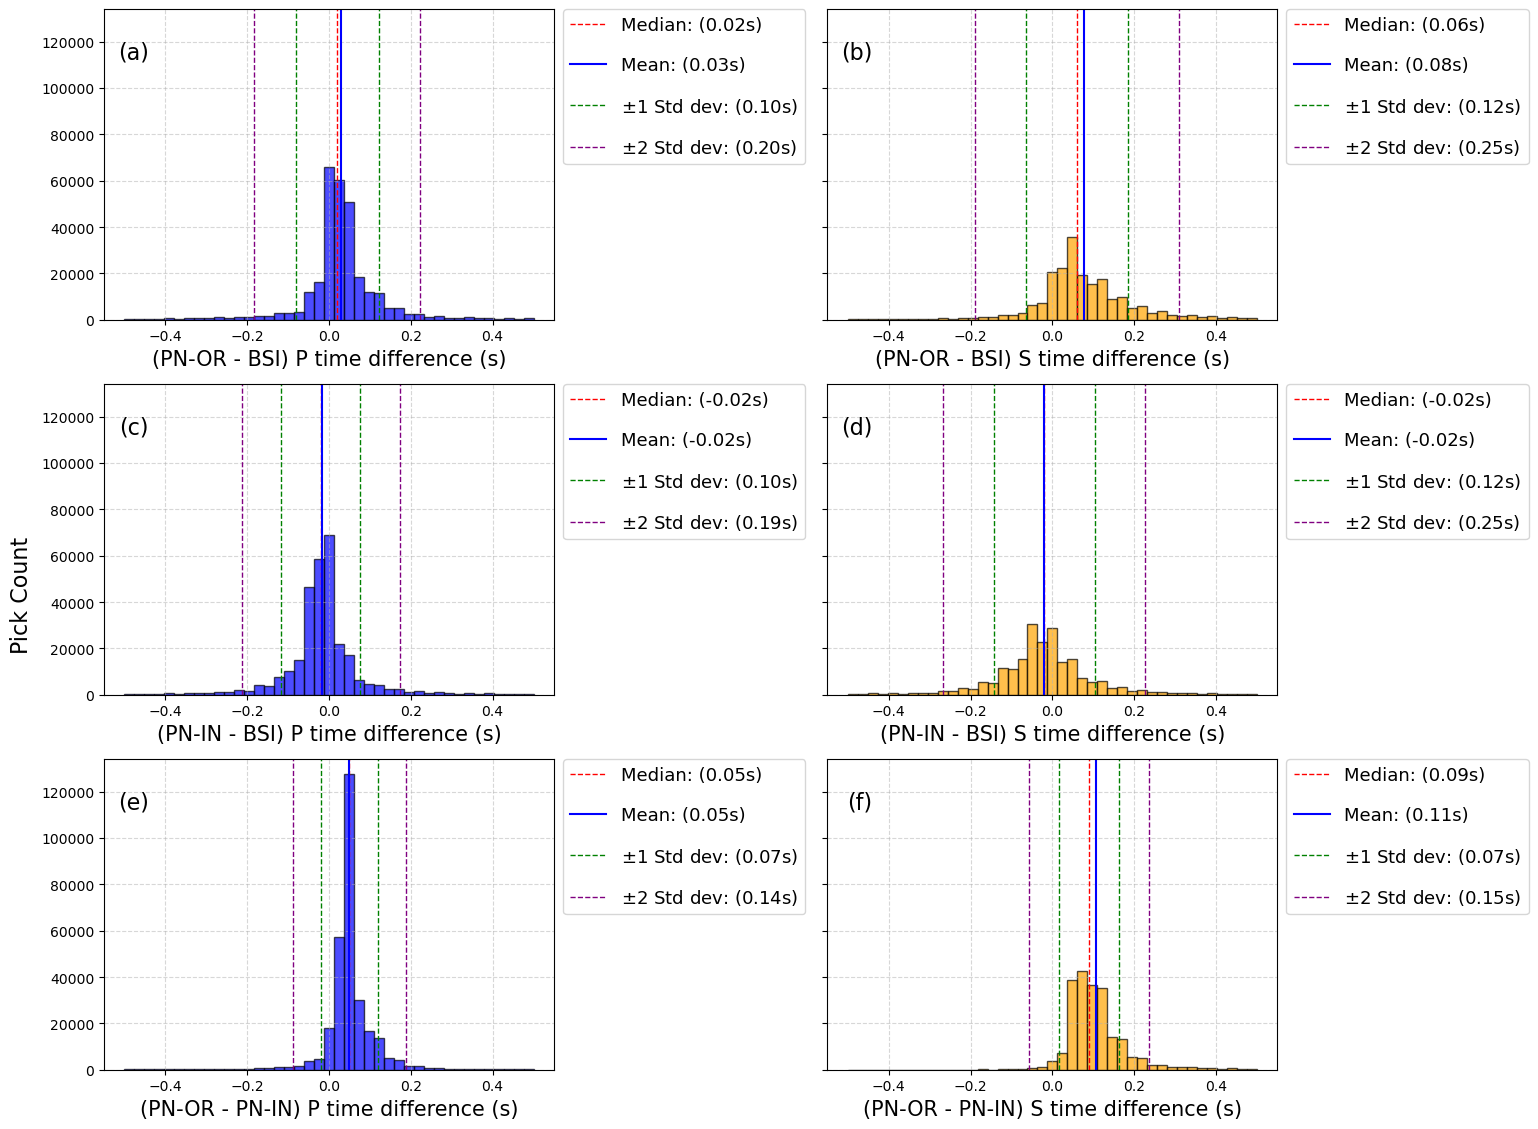

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Filtra i dati per le diverse phase_hint
data_p = merged_df[merged_df['phase_hint'] == 'P']
data_s = merged_df[merged_df['phase_hint'] == 'S']

# Calcola le differenze per i grafici
diff_ingv_or_p = (data_p['UTCDateTime_or'] - data_p['UTCDateTime_ingv'])
diff_ingv_or_s = (data_s['UTCDateTime_or'] - data_s['UTCDateTime_ingv'])
diff_ingv_in_p = (data_p['UTCDateTime_in'] - data_p['UTCDateTime_ingv'])
diff_ingv_in_s = (data_s['UTCDateTime_in'] - data_s['UTCDateTime_ingv'])
diff_or_in_p = (data_p['UTCDateTime_or'] - data_p['UTCDateTime_in'])
diff_or_in_s = (data_s['UTCDateTime_or'] - data_s['UTCDateTime_in'])


# Crea la figura con 6 pannelli (3x2)
fig, axes = plt.subplots(3, 2, figsize=(16, 12),sharey=True)

# Prima riga: UTCDateTime_ingv - UTCDateTime_or
plot_histogram_with_stats(axes[0, 0], diff_ingv_or_p, "",color='blue')
plot_histogram_with_stats(axes[0, 1], diff_ingv_or_s, '', color='orange')

# Seconda riga: UTCDateTime_ingv - UTCDateTime_in
plot_histogram_with_stats(axes[1, 0], diff_ingv_in_p, '', color='blue')
plot_histogram_with_stats(axes[1, 1], diff_ingv_in_s, '', color='orange')

# Terza riga: UTCDateTime_or - UTCDateTime_in
plot_histogram_with_stats(axes[2, 0], diff_or_in_p, '', color='blue')
plot_histogram_with_stats(axes[2, 1], diff_or_in_s, '', color='orange')

axes[0, 0].set_xlabel(f'(PN-OR - BSI) P time difference (s)',fontsize=15)
axes[0, 1].set_xlabel(f'(PN-OR - BSI) S time difference (s)',fontsize=15)
axes[1, 0].set_xlabel(f'(PN-IN - BSI) P time difference (s)',fontsize=15)
axes[1, 1].set_xlabel(f'(PN-IN - BSI) S time difference (s)',fontsize=15)
axes[2, 0].set_xlabel(f'(PN-OR - PN-IN) P time difference (s)',fontsize=15)
axes[2, 1].set_xlabel(f'(PN-OR - PN-IN) S time difference (s)',fontsize=15)


# Aggiungi etichette per i pannelli
axes[0, 0].text(0.1, 0.9, '(a)',
                transform=axes[0, 0].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')
axes[0, 1].text(0.1, 0.9, '(b)',
                transform=axes[0, 1].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')

axes[1, 0].text(0.1, 0.9, '(c)',
                transform=axes[1, 0].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')
axes[1, 1].text(0.1, 0.9, '(d)',
                transform=axes[1, 1].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')
axes[2, 0].text(0.1, 0.9, '(e)',
                transform=axes[2, 0].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')
axes[2, 1].text(0.1, 0.9, '(f)',
                transform=axes[2, 1].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')


# Etichette comuni
# fig.text(0.5, 0.04, 'Time Difference (seconds)', ha='center')
fig.text(0.04, 0.5, 'Pick Count', va='center', rotation='vertical',fontsize=16)
plt.subplots_adjust(hspace=0.4)  # Aumenta lo spazio verticale tra le righe

# Layout e visualizzazione
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
# plt.tight_layout()
plt.savefig('./FIGURE/residual_hist_IN_OR_BSI.png',dpi=300)
plt.show()
